Import Libraries

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

Load the Dataset

In [4]:
data = pd.read_csv('Housing.csv')
print(data.shape)
print(data.head())

(545, 13)
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


Data Preprocessing

In [5]:
# Check for missing values
print("Missing values in each column:\n", data.isnull().sum())

# Remove 'prefarea' feature because it contains only missing values
data = data.drop(columns=['prefarea'])

# Encode other categorical variables
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                    'airconditioning', 'furnishingstatus']

# Use pd.get_dummies to encode categorical variables
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Separate features and target
X = data_encoded.drop('price', axis=1)
y = data_encoded['price']


# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Missing values in each column:
 price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


Train-Test Split (80% - 20%)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

Kernelized Ridge Regression Implementation

In [7]:
# Kernel functions remain the same

def polynomial_kernel(degree=3, coef0=1):
    def thunk(X,Y):
        """Compute the polynomial kernel between X and Y."""
        return (np.dot(X, Y.T) + coef0) ** degree
    return thunk

def rbf_kernel(gamma):
    def thunk(X,Y):
        """Compute the RBF (Gaussian) kernel between X and Y."""
        X_norm = np.sum(X ** 2, axis=1)
        Y_norm = np.sum(Y ** 2, axis=1)
        K = np.exp(-gamma * (
            X_norm[:, np.newaxis] + Y_norm[np.newaxis, :] - 2 * np.dot(X, Y.T)))
        return K
    return thunk

# Updated Kernel Ridge Regression class
class KernelRidgeRegression:
    def __init__(self, kernel, l=1.0):
        """
        Initialize the Kernel Ridge Regression model.

        Parameters:
        - kernel: string, specifies the kernel type ('linear', 'polynomial', 'rbf')
        - alpha: float, regularization parameter
        - kernel_params: additional parameters for the kernel function
        """
        self.l = l
        self.kernel = kernel

    def fit(self, X, y):
        """
        Fit the Kernel Ridge Regression model using the derived formulas.

        Parameters:
        - X: array-like of shape (n_samples, n_features), training data
        - y: array-like of shape (n_samples,), target values
        """
        self.X_train = X  
        self.y_train = y  
        
        self.K_train = self.kernel(X, X)
        
        n_samples = self.K_train.shape[0]
        self.K_reg = self.K_train + self.l * np.eye(n_samples)
        
        self.alpha = np.linalg.solve(self.K_reg, y)

    def predict(self, X):
        """
        Predict using the Kernel Ridge Regression model.

        Parameters:
        - X: array-like of shape (n_samples, n_features), input data

        Returns:
        - y_pred: array-like of shape (n_samples,), predicted values
        """
        # kernel matrix K(X_test, X_train)
        K_test = self.kernel(X, self.X_train)
        
        # y_pred = K_test @ α
        y_pred = K_test @ self.alpha
        return y_pred


# Model Training and Prediction

In [8]:
# to complete
best_mse = float('inf')
best_gamma = None
best_lambda = None

for gamma in [0.001, 0.01, 0.1, 1, 10]:
    for l in [0.01, 0.1, 1, 10]:
        kernel_func = rbf_kernel(gamma)
        model_krr = KernelRidgeRegression(kernel=kernel_func, l=l)
        model_krr.fit(X_train, y_train)
        y_pred_krr = model_krr.predict(X_test)
        mse_krr = mean_squared_error(y_test, y_pred_krr)
        
        if mse_krr < best_mse:
            best_mse = mse_krr
            best_gamma = gamma
            best_lambda = l

print(f"Best gamma: {best_gamma}, Best λ: {best_lambda}, Best MSE: {best_mse}")

Best gamma: 0.001, Best λ: 0.01, Best MSE: 1798280307724.2747


In [9]:
# train a model with best parameters
kernel_func = rbf_kernel(gamma=best_gamma)
model_krr = KernelRidgeRegression(kernel=kernel_func, l=0.01)
model_krr.fit(X_train, y_train)
y_pred_krr = model_krr.predict(X_test)

Results Comparison

In [10]:
kernel_func = polynomial_kernel(degree=3, coef0=1)
model_krr_linear = KernelRidgeRegression(kernel=kernel_func, l=l)
model_krr_linear.fit(X_train, y_train)
y_pred_krr_linear = model_krr_linear.predict(X_test)

In [11]:
# Define a function to compute evaluation metrics
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} - Mean Squared Error: {mse:,.2f}, Mean Absolute Error: {mae:,.2f}")
    return mse


# Evaluate Kernelized Ridge Regression with Linear kernel
mse_krr_linear = evaluate_model(
    y_test, y_pred_krr_linear, "Kernelized Ridge Regression (Linear Kernel)")



Kernelized Ridge Regression (Linear Kernel) - Mean Squared Error: 11,147,336,855,673.51, Mean Absolute Error: 1,916,918.20


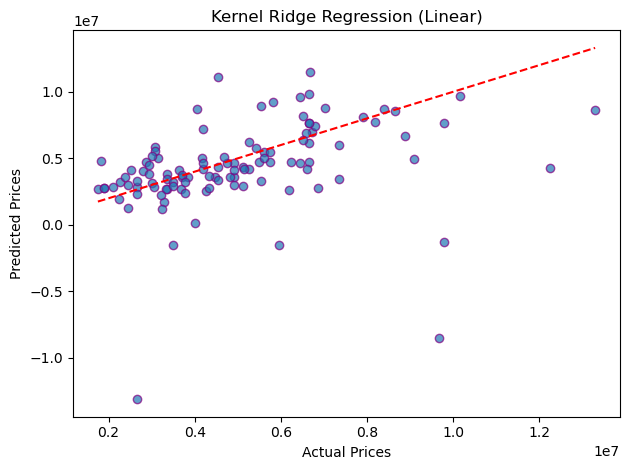

In [12]:
# Plotting true vs predicted values for each model
#plt.figure(figsize=(24, 5))

def plot_results(y_true, y_pred, model_name):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolors='purple')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title(f"Kernel Ridge Regression ({model_name})")
    plt.tight_layout()
    plt.show()


plot_results(y_test, y_pred_krr_linear, "Linear")

